Importing all the libraries that we will need for machine learning

In [1]:
#Knn
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage import data, color, img_as_float, img_as_ubyte, filters, feature
from skimage import draw as drw
import matplotlib.ticker as plticker
from PIL import Image, ImageDraw
import matplotlib.patches as patches
import csv
import math
%matplotlib inline
from IPython.display import HTML, display
import numpy as np
from sklearn import preprocessing, cross_validation, neighbors
import pandas as pd
from pandas import DataFrame
import csv
from skimage import data, color, img_as_float, img_as_ubyte, filters, feature
import matplotlib.pyplot as plt
from numpy import genfromtxt
from sklearn import preprocessing
import timeit
from sklearn.ensemble import RandomForestClassifier


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


                                    DOWNLOADING IMAGE TO BE TESTED

Text(0.5,1,'Retina Image')

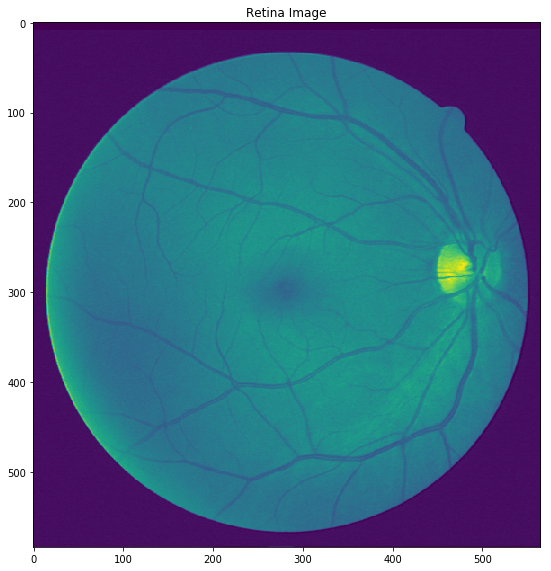

In [2]:
# importing image for testing
retina_image =  '19_test.tif' 

# Converting image into grey scale 
retina = data.imread(retina_image)
retina_grey = color.rgb2grey(retina)

# Displaying image
plt.figure(figsize=(20,18))
plt.subplot(121)
plt.imshow(retina_grey)
plt.title('Retina Image')


Spliting image into a grind, each square in the grind will be analysed to by machine learning lagorithm 
to "see" if in that square there is a vessel or not

In [3]:
# Choosing grind size
grid_size = 2

Importing features matrix (training data matrix) from "data_preparation" folder, we will use it here to train our model

In [5]:
# Accessing "feature_vectors.csv" file from data_preparation folder and storing it in "read_anothers_folder_csv"
read_anothers_folder_csv = pd.read_csv('../../data_preparation/patches.csv') #read csv feature vectors csv file from data_preparation folder


We now need to label the last column in training data as "class", this column contains 1 and -1 (vessel, not vessel)

In [6]:
# Generating array that has last entry as class, we will add this array to our csv file that contains training data.
# the array looks like this [p,p,p,p,p,p,p,p..........'class']
# p's dont matter, it could be anything, just to name columns somehow.
array = []
for gr in range(grid_size**2):
    array.append('p')
array.append('class')   

# Add columns name to features_vectors data 
df2 = pd.DataFrame(read_anothers_folder_csv)
df2.columns= array  
# Overwriting the training data csv, it now has "class" column name at the end, now we can do machine learning
df2.to_csv('processed_data.csv',index=False)            

                                          RANDOM FOREST CODE
                                             
This is Random Forest code from sklearn library, the hyperparameters are choosen here from tunning example we done in "Tunning_Random_Forest " folder
In this code we split the data into traning set and testing set and then predict the accuracy

In [13]:
# Reading training data from processed_data.csv folder
df = pd.read_csv('processed_data.csv')  
x = np.array(df.drop(['class'],1))
y = np.array(df['class'])

# Normalising the data in range (0,1), we need to normalise this data because retina images come in many shades
# and this will reduce performance of the model significantly
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(x)

# Spliting the data into train and test sets, the training set is 20% and test set is 80% in size
x_train, x_test, y_train, y_test = cross_validation.train_test_split(X_train_minmax,y,test_size=0.2)

# Accessing sklearn library for this classifier
clf = RandomForestClassifier(n_estimators=10,min_samples_leaf = 8)
#clf = RandomForestClassifier(n_estimators=1000,min_samples_leaf = 2, max_features = 1)

clf.fit(x_train,y_train)

# Displaying the result
print('Accuracy on the training subset: {:.3f}'.format(clf.score(x_train,y_train)))
print('Accuracy on the testing subset: {:.3f}'.format(clf.score(x_test,y_test)))

Accuracy on the training subset: 0.918
Accuracy on the testing subset: 0.899


                                        TESTING ON NEW IMAGE 
                              
Now we will use this model to test on new image and see if it can detect vessels, we will break image into a grid
and analyse every single square to "check for vessel" we will label it -1 if there is no vessel and 1 if there is vessel

In [5]:
# This function calculates how many squares fit along x_axis given our grid size and number of squares along y_axis
# We dont want image to end on a fraction of a grid
def rounding_function(rounding_image):#rounding down funcion 

    # rounding_image[1] is our image array size in pixels along x_axis(width)
    #we are rounding to nearest integer
    number_of_x_steps = rounding_image.shape[1]/grid_size
    round_down_number_x = math.floor(number_of_x_steps)
    
    
    # rounding_image[0] is our image array size in pixels along y_axis(length)
    #we are rounding to nearest integer
    number_of_y_steps = rounding_image.shape[0]/grid_size
    round_down_number_y = math.floor(number_of_y_steps)
    
    
    #Return array storing rounded off number of "grid steps" along width and length
    rounding = [round_down_number_x,round_down_number_y]
    return rounding

                                                DISPLAY RESULT

Here the we have double nested loop, inner loop will got row by row "looking for vessels",

-- each square in the grid will be converted to array
-- array will be flattened into one line array
-- flat array will be passed to our classifier
-- predicition will be made -1 or 1
-- if prediction is -1 that grid square will be populated with zeros else with will be populated with ones 

In [6]:
# Function that runs throught all of the row "looking for vessels"
def populate_row(y):
    
    # Calculating how many squares we need to run through in x_axis
    grid_rounding = rounding_function(retina_grey)
    allArrays = np.array([[0, 0], [0, 0]])
    
    # Inner loop, running along the rows, from begining (0) to last square (grid_rounding[0])
    for x in range(0, grid_rounding[0]):
        
        # Indexing out image, square by square
        arr = retina_grey[0 + grid_size*y:grid_size + grid_size*y,0 + grid_size*x:grid_size + grid_size*x]
       # Flattening array
        feature_vector = arr.flatten()             
       
        # Passing flat array into example_measures variable
        example_measures = ([feature_vector])
        #passing example_measures variable into our classifier to give preddiction of 1 or -1 
        prediction = clf.predict(example_measures)
     
        
        
        
        # If there is no vessel in this square then populate it with zeros [0,0][0,0] 
        # If there is a vessel populate it with [1,1][1,1]
        prediction_array = []
        
        # If prediciton is 0 (no vessel, populate that grid square with zeros else with ones 
        if prediction == 0:
               prediction_array =  np.zeros((grid_size,grid_size))
        else: 
                prediction_array = np.ones((grid_size,grid_size))
        
        
        # Concatinate the grid with new grid vales of all zero or all one
        myArray = np.array(prediction_array)
        allArrays = np.concatenate([allArrays, myArray],axis=1)
        # Return this concatinated row
    return allArrays

In [7]:
# This block of code is outer loop, it will populate the grid with rows in y_axis 

# Calculating how many squares we need to run through in y_axis
grid_rounding = rounding_function(retina_grey)

row_array = populate_row(0)
# first row is all zeros, for some reason I had to do this or it was giving me erros
s = (2,row_array.shape[1])
allArrays=np.zeros(s)

# Popilate image with rows up to the end grid_rounding[1]
for y in range(0,grid_rounding[1]):
    row_array = populate_row(y)
    
    # store this ever increasing matrix in myArray
    myArray = np.array(row_array)
    allArrays = np.concatenate([allArrays, myArray],axis=0)
    
    #Display values row by row 
    print(allArrays)


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. 

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [8]:
#From now on we will multiply the resultant matrix by image matrix to see our final result image

# We need to remove first row and colum from our predicted final matrix, this is because there is size mistmatch 
# between image matrix and our result matrix
eddited_allArrays_rows = np.delete(allArrays, (0,1),  axis=0)
eddited_allArrays_columns = np.delete(eddited_allArrays_rows, (0),  axis=1)


In [9]:
# Store the multiplicaiton of predicted matrix multiplied by image matrix in "final_array"
final_array = retina_grey*eddited_allArrays_columns 

                                            DISPLAY RESULT

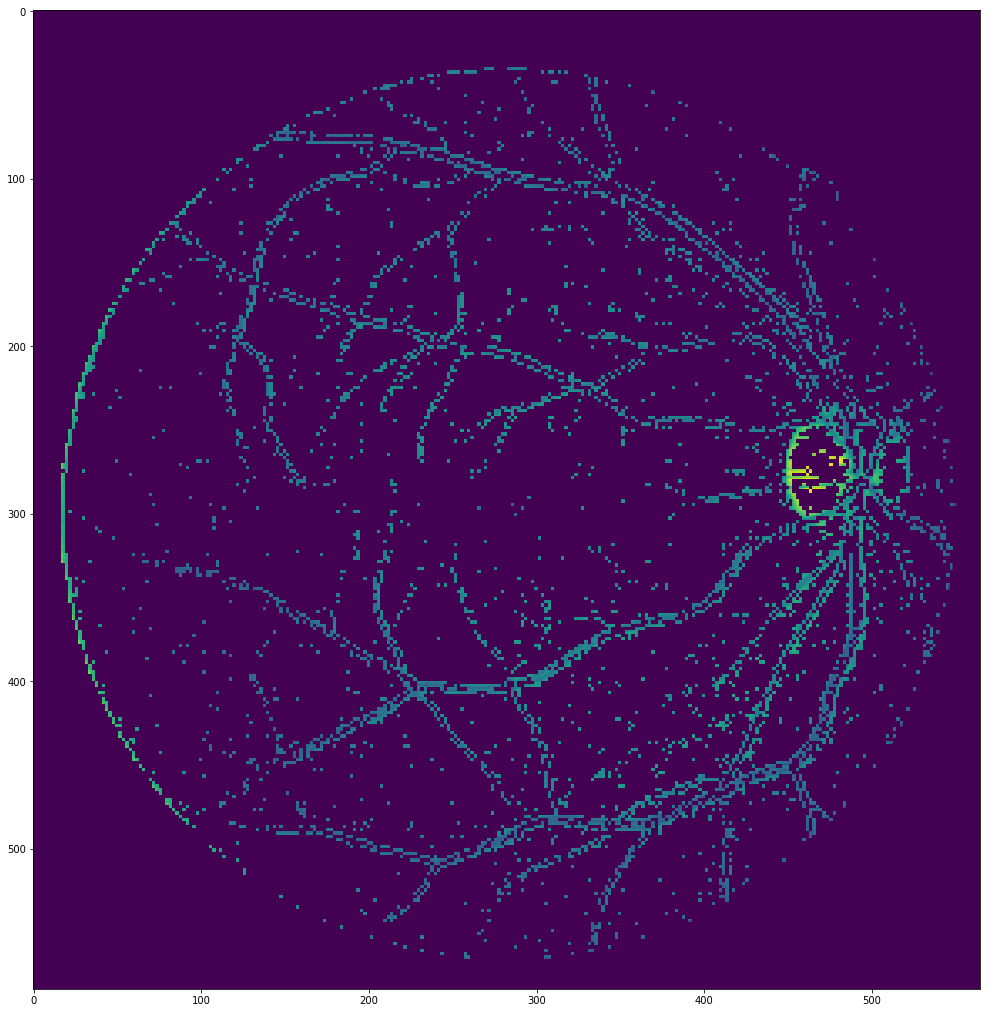

In [10]:
# Display results of our work and save image into this folder 
plt.figure(figsize=(20,18))
plt.imshow(final_array)
plt.imsave('knn_1i_3n.png', final_array)

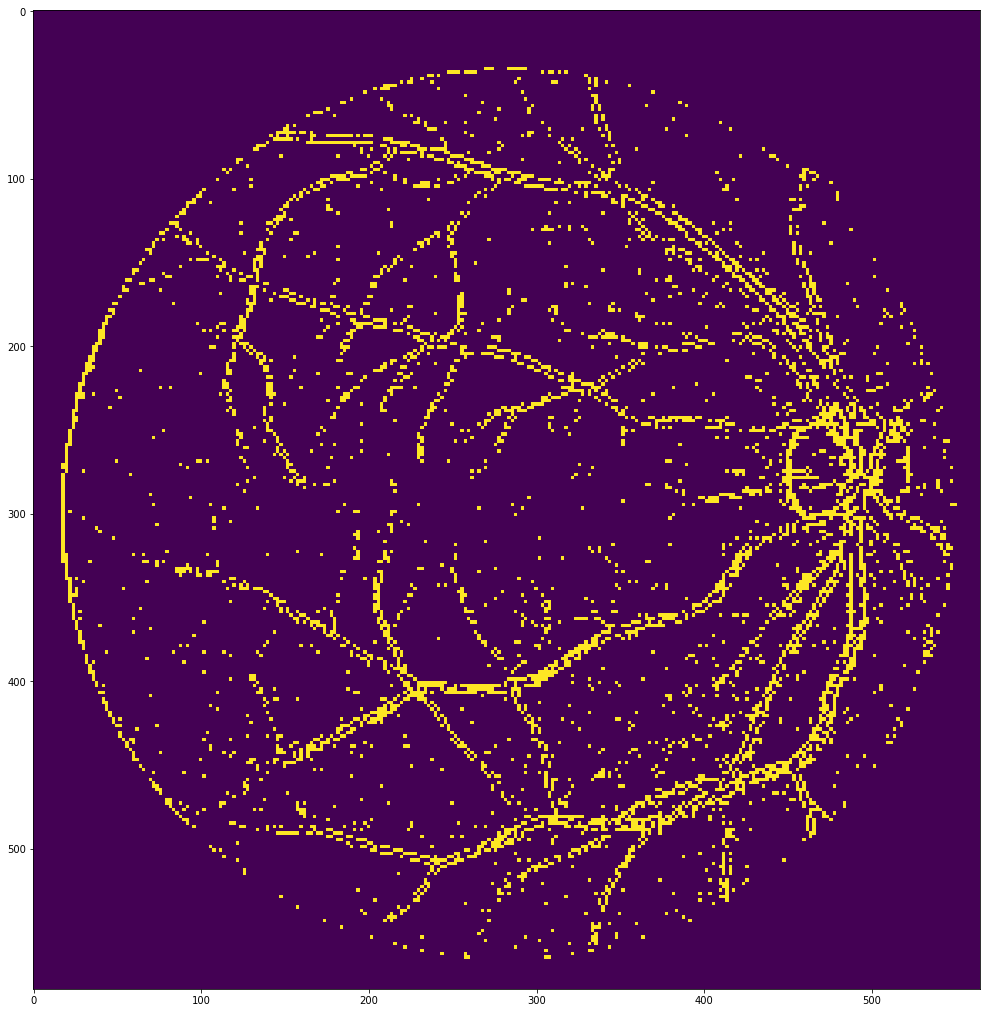

In [11]:
# Display result of predicted matrix without multipling it by image matrix 
plt.figure(figsize=(20,18))
plt.imshow(eddited_allArrays_columns)